In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset

from torchvision import datasets, transforms, models
from torchvision.transforms import functional as F

from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from matplotlib import pyplot as plt

import os
import sys

In [77]:
# Загружаем CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Случайный горизонтальный флип с вероятностью 50%
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Случайное изменение цветового баланса
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
data_len = train_dataset.__len__()

In [79]:
# Глобальные параметры
INITIAL_TRAIN = 0.2                        # Начальные данные
BATCH_ADD_SIZE = 256                       # K данных для добавления
TOTAL_TRAIN_SIZE = data_len                 # Общее количество тренировочных данных
NUM_CLASSES = 10                            # CIFAR-10

In [80]:
# Задаем пропорцию выборки
p = INITIAL_TRAIN 

# Загрузка данных
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# Группируем индексы по классам
class_indices = {class_idx: [] for class_idx in range(NUM_CLASSES)}
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

# Разделяем данные
initial_indices = []
pool_indices = []

for class_idx, indices in class_indices.items():
    np.random.shuffle(indices)  # Перемешиваем индексы внутри класса
    split_idx = int(len(indices) * p)  # Вычисляем границу разделения
    initial_indices.extend(indices[:split_idx])
    pool_indices.extend(indices[split_idx:])

# Создаем подмножества данных
initial_train_dataset = Subset(train_dataset, initial_indices)
pool_dataset = Subset(train_dataset, pool_indices)

print(f"Размер initial_train_dataset: {len(initial_train_dataset)}")
print(f"Размер pool_dataset: {len(pool_dataset)}")

Files already downloaded and verified
Размер initial_train_dataset: 10000
Размер pool_dataset: 40000


In [81]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from base_trainer import Trainer
from model import SimpleCNN
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'EGL')))

In [82]:
import random


class EGLTrainer(Trainer):
    def select_samples(self, num_samples):
        # total_samples = len(self.pool_loader.dataset)
        # r = random.sample(range(total_samples), num_samples)
        # self.update_dataloader(r)
        # return r
        self.model.eval()
        self.pool_loader
        

        gradient_lengths = []
        ###
        ### Этот комментарий в память о тройном цикле for от чата gpt >_<
        ###
        for inputs, _ in tqdm(self.pool_loader, desc="Thingy"):
            inputs = inputs.to(self.device)
            

            # Получаем выходы модели
            outputs = self.model(inputs)  # Tensor [batch_size, num_classes]
            probabilities = torch.softmax(outputs, dim=1)  # Tensor [batch_size, num_classes]

            # Создаем вектор one-hot меток для всех классов
            one_hot_labels = torch.eye(outputs.size(1), device=self.device)  # Tensor [num_classes, num_classes]

            # Расширяем one-hot метки для батча
            expanded_labels = one_hot_labels.unsqueeze(0).repeat(outputs.size(0), 1, 1)  # [batch_size, num_classes, num_classes]

            # Расширяем выходы модели для вычитания
            expanded_outputs = outputs.unsqueeze(1).repeat(1, outputs.size(1), 1)  # [batch_size, num_classes, num_classes]

            # Вычисляем потери для всех пар (объект, метка) в батче
            losses = self.criterion(expanded_outputs.view(-1, outputs.size(1)), expanded_labels.view(-1, outputs.size(1)))  # [batch_size * num_classes]

            # Считаем градиенты для всех потерь
            grads = torch.autograd.grad(
                losses.sum(),
                self.model.parameters(),
                retain_graph=True,
                create_graph=False
            )

            # Вычисляем длины градиентов
            grad_square_norms = torch.norm(torch.cat([g.view(-1) for g in grads])) # torch.cat([g.flatten(1).pow(2).sum(1) for g in grads]).sum(dim=0)  # [batch_size, num_classes]

            # Мат ожидание
            batch_gradient_expectations = (probabilities * grad_square_norms).sum(dim=1)  # [batch_size]

            gradient_lengths.extend(batch_gradient_expectations.cpu().detach().numpy())

        # Выбираем `num_samples` с максимальной длиной градиента
        informative_indices = torch.topk(torch.tensor(gradient_lengths), num_samples).indices

        self.update_dataloader(informative_indices)
        return informative_indices
    
    def update_dataloader(self, samples_index):
        """
        Обновляем даталоудеры
        """
        samples = [self.pool_loader.dataset[i] for i in samples_index]


        new_train_data = ConcatDataset([self.train_loader.dataset, samples])
        
        self.train_loader = DataLoader(new_train_data,
                                       batch_size=self.train_loader.batch_size,
                                       shuffle=True,
                                       num_workers=self.train_loader.num_workers)
        

        all_indexes = list(range(len(self.pool_loader.dataset)))
        
        filtered_indexes = [idx for idx in all_indexes if idx not in samples_index]

        new_pool_data = Subset(self.pool_loader.dataset, filtered_indexes)

        self.pool_loader = DataLoader(new_pool_data,
                                      batch_size=self.pool_loader.batch_size,
                                      shuffle=True,
                                      num_workers=self.pool_loader.num_workers)
    
    def fit(self, num_epochs, num_samples = BATCH_ADD_SIZE):

        """
        Полный цикл обучения.
        :param num_epochs: Количество эпох
        """
        for epoch in range(num_epochs):

            train_loss = self.train_step()
            val_loss, accuracy, f1 = self.val_step()
            if len(self.pool_loader.dataset) > num_samples:
                self.select_samples(num_samples)
            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")




In [83]:
train_dataloader = DataLoader(initial_train_dataset, batch_size=128, shuffle=True)
pool_dataloader = DataLoader(pool_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [84]:
model = SimpleCNN(10)

In [85]:
EPOCHS = 50
learning_rate = 5e-4
total_steps = len(train_dataloader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=4e-6)
# from adabelief_pytorch import AdaBelief
# optimizer = AdaBelief(model.parameters(), lr=learning_rate, eps=learning_rate, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=False, rectify=True, print_change_log = False)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate , total_steps=total_steps, pct_start=0.1, anneal_strategy='linear')


In [86]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE


'cuda'

In [87]:
trainer = EGLTrainer(model=model.to(DEVICE), 
                     optimizer=optimizer,
                     criterion=criterion, 
                     train_loader=train_dataloader,
                     val_loader=val_dataloader, 
                     device=DEVICE, 
                     scheduler = None,
                     pool_loader= pool_dataloader)

In [88]:
trainer.fit(EPOCHS)


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.40it/s]


Validation Loss: 3.5883, Accuracy: 0.2079, F1 Score: 0.1570


Thingy: 100%|██████████| 313/313 [00:06<00:00, 46.61it/s]


Epoch 1/50 - Train Loss: 2.0517, Val Loss: 3.5883, Acc: 0.2079, F1: 0.1570


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.73it/s]


Validation Loss: 5.9884, Accuracy: 0.2032, F1 Score: 0.1469


Thingy: 100%|██████████| 311/311 [00:06<00:00, 45.70it/s]


Epoch 2/50 - Train Loss: 1.7610, Val Loss: 5.9884, Acc: 0.2032, F1: 0.1469


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.59it/s]


Validation Loss: 6.8766, Accuracy: 0.1827, F1 Score: 0.1383


Thingy: 100%|██████████| 309/309 [00:06<00:00, 45.86it/s]


Epoch 3/50 - Train Loss: 1.6189, Val Loss: 6.8766, Acc: 0.1827, F1: 0.1383


Validating: 100%|██████████| 79/79 [00:02<00:00, 38.29it/s]


Validation Loss: 5.8637, Accuracy: 0.2685, F1 Score: 0.2224


Thingy: 100%|██████████| 307/307 [00:06<00:00, 45.51it/s]


Epoch 4/50 - Train Loss: 1.5539, Val Loss: 5.8637, Acc: 0.2685, F1: 0.2224


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.68it/s]


Validation Loss: 6.2356, Accuracy: 0.2623, F1 Score: 0.2248


Thingy: 100%|██████████| 305/305 [00:06<00:00, 46.10it/s]


Epoch 5/50 - Train Loss: 1.4916, Val Loss: 6.2356, Acc: 0.2623, F1: 0.2248


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.31it/s]


Validation Loss: 5.6810, Accuracy: 0.3020, F1 Score: 0.2649


Thingy: 100%|██████████| 303/303 [00:06<00:00, 43.97it/s]


Epoch 6/50 - Train Loss: 1.4389, Val Loss: 5.6810, Acc: 0.3020, F1: 0.2649


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.51it/s]


Validation Loss: 5.9189, Accuracy: 0.2976, F1 Score: 0.2549


Thingy: 100%|██████████| 301/301 [00:06<00:00, 45.06it/s]


Epoch 7/50 - Train Loss: 1.3948, Val Loss: 5.9189, Acc: 0.2976, F1: 0.2549


Validating: 100%|██████████| 79/79 [00:02<00:00, 38.05it/s]


Validation Loss: 5.1237, Accuracy: 0.3358, F1 Score: 0.3048


Thingy: 100%|██████████| 299/299 [00:06<00:00, 44.29it/s]


Epoch 8/50 - Train Loss: 1.3549, Val Loss: 5.1237, Acc: 0.3358, F1: 0.3048


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.79it/s]


Validation Loss: 5.9976, Accuracy: 0.3143, F1 Score: 0.2825


Thingy: 100%|██████████| 297/297 [00:06<00:00, 43.72it/s]


Epoch 9/50 - Train Loss: 1.3055, Val Loss: 5.9976, Acc: 0.3143, F1: 0.2825


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.33it/s]


Validation Loss: 5.6546, Accuracy: 0.3272, F1 Score: 0.3006


Thingy: 100%|██████████| 295/295 [00:06<00:00, 44.37it/s]


Epoch 10/50 - Train Loss: 1.2815, Val Loss: 5.6546, Acc: 0.3272, F1: 0.3006


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.65it/s]


Validation Loss: 5.4705, Accuracy: 0.3516, F1 Score: 0.3141


Thingy: 100%|██████████| 293/293 [00:06<00:00, 44.80it/s]


Epoch 11/50 - Train Loss: 1.2407, Val Loss: 5.4705, Acc: 0.3516, F1: 0.3141


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.12it/s]


Validation Loss: 5.3901, Accuracy: 0.3477, F1 Score: 0.3181


Thingy: 100%|██████████| 291/291 [00:06<00:00, 44.77it/s]


Epoch 12/50 - Train Loss: 1.2219, Val Loss: 5.3901, Acc: 0.3477, F1: 0.3181


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.77it/s]


Validation Loss: 5.7062, Accuracy: 0.3597, F1 Score: 0.3214


Thingy: 100%|██████████| 289/289 [00:06<00:00, 44.40it/s]


Epoch 13/50 - Train Loss: 1.1949, Val Loss: 5.7062, Acc: 0.3597, F1: 0.3214


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.23it/s]


Validation Loss: 5.4356, Accuracy: 0.3550, F1 Score: 0.3219


Thingy: 100%|██████████| 287/287 [00:06<00:00, 42.28it/s]


Epoch 14/50 - Train Loss: 1.1617, Val Loss: 5.4356, Acc: 0.3550, F1: 0.3219


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.83it/s]


Validation Loss: 5.5992, Accuracy: 0.3528, F1 Score: 0.3229


Thingy: 100%|██████████| 285/285 [00:06<00:00, 44.23it/s]


Epoch 15/50 - Train Loss: 1.1346, Val Loss: 5.5992, Acc: 0.3528, F1: 0.3229


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.59it/s]


Validation Loss: 5.7384, Accuracy: 0.3416, F1 Score: 0.3134


Thingy: 100%|██████████| 283/283 [00:06<00:00, 43.81it/s]


Epoch 16/50 - Train Loss: 1.1235, Val Loss: 5.7384, Acc: 0.3416, F1: 0.3134


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.14it/s]


Validation Loss: 5.5927, Accuracy: 0.3560, F1 Score: 0.3268


Thingy: 100%|██████████| 281/281 [00:06<00:00, 44.09it/s]


Epoch 17/50 - Train Loss: 1.0943, Val Loss: 5.5927, Acc: 0.3560, F1: 0.3268


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.22it/s]


Validation Loss: 5.8567, Accuracy: 0.3382, F1 Score: 0.3045


Thingy: 100%|██████████| 279/279 [00:06<00:00, 44.11it/s]


Epoch 18/50 - Train Loss: 1.0752, Val Loss: 5.8567, Acc: 0.3382, F1: 0.3045


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.76it/s]


Validation Loss: 5.2849, Accuracy: 0.3594, F1 Score: 0.3261


Thingy: 100%|██████████| 277/277 [00:06<00:00, 43.94it/s]


Epoch 19/50 - Train Loss: 1.0582, Val Loss: 5.2849, Acc: 0.3594, F1: 0.3261


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.74it/s]


Validation Loss: 5.1930, Accuracy: 0.3742, F1 Score: 0.3494


Thingy: 100%|██████████| 275/275 [00:06<00:00, 43.27it/s]


Epoch 20/50 - Train Loss: 1.0455, Val Loss: 5.1930, Acc: 0.3742, F1: 0.3494


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.84it/s]


Validation Loss: 6.3432, Accuracy: 0.3478, F1 Score: 0.3134


Thingy: 100%|██████████| 273/273 [00:06<00:00, 43.41it/s]


Epoch 21/50 - Train Loss: 1.0197, Val Loss: 6.3432, Acc: 0.3478, F1: 0.3134


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.90it/s]


Validation Loss: 5.9034, Accuracy: 0.3574, F1 Score: 0.3303


Thingy: 100%|██████████| 271/271 [00:06<00:00, 44.65it/s]


Epoch 22/50 - Train Loss: 0.9990, Val Loss: 5.9034, Acc: 0.3574, F1: 0.3303


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.47it/s]


Validation Loss: 5.5293, Accuracy: 0.3745, F1 Score: 0.3434


Thingy: 100%|██████████| 269/269 [00:06<00:00, 43.75it/s]


Epoch 23/50 - Train Loss: 0.9876, Val Loss: 5.5293, Acc: 0.3745, F1: 0.3434


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.23it/s]


Validation Loss: 6.1237, Accuracy: 0.3478, F1 Score: 0.3163


Thingy: 100%|██████████| 267/267 [00:06<00:00, 41.95it/s]


Epoch 24/50 - Train Loss: 0.9653, Val Loss: 6.1237, Acc: 0.3478, F1: 0.3163


Validating: 100%|██████████| 79/79 [00:02<00:00, 37.64it/s]


Validation Loss: 5.4229, Accuracy: 0.3871, F1 Score: 0.3655


Thingy: 100%|██████████| 265/265 [00:06<00:00, 39.06it/s]


Epoch 25/50 - Train Loss: 0.9304, Val Loss: 5.4229, Acc: 0.3871, F1: 0.3655


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.09it/s]


Validation Loss: 4.8828, Accuracy: 0.4047, F1 Score: 0.3898


Thingy: 100%|██████████| 263/263 [00:06<00:00, 42.60it/s]


Epoch 26/50 - Train Loss: 0.9200, Val Loss: 4.8828, Acc: 0.4047, F1: 0.3898


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.48it/s]


Validation Loss: 5.1812, Accuracy: 0.4019, F1 Score: 0.3874


Thingy: 100%|██████████| 261/261 [00:06<00:00, 43.16it/s]


Epoch 27/50 - Train Loss: 0.9030, Val Loss: 5.1812, Acc: 0.4019, F1: 0.3874


Validating: 100%|██████████| 79/79 [00:02<00:00, 38.24it/s]


Validation Loss: 5.6370, Accuracy: 0.3896, F1 Score: 0.3652


Thingy: 100%|██████████| 259/259 [00:05<00:00, 47.84it/s]


Epoch 28/50 - Train Loss: 0.8773, Val Loss: 5.6370, Acc: 0.3896, F1: 0.3652


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.06it/s]


Validation Loss: 5.7042, Accuracy: 0.3842, F1 Score: 0.3561


Thingy: 100%|██████████| 257/257 [00:06<00:00, 42.67it/s]


Epoch 29/50 - Train Loss: 0.8698, Val Loss: 5.7042, Acc: 0.3842, F1: 0.3561


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.63it/s]


Validation Loss: 5.4971, Accuracy: 0.4043, F1 Score: 0.3795


Thingy: 100%|██████████| 255/255 [00:06<00:00, 40.90it/s]


Epoch 30/50 - Train Loss: 0.8543, Val Loss: 5.4971, Acc: 0.4043, F1: 0.3795


Validating: 100%|██████████| 79/79 [00:02<00:00, 37.92it/s]


Validation Loss: 4.9588, Accuracy: 0.4305, F1 Score: 0.4033


Thingy: 100%|██████████| 253/253 [00:05<00:00, 42.36it/s]


Epoch 31/50 - Train Loss: 0.8418, Val Loss: 4.9588, Acc: 0.4305, F1: 0.4033


Validating: 100%|██████████| 79/79 [00:02<00:00, 38.96it/s]


Validation Loss: 5.7766, Accuracy: 0.3871, F1 Score: 0.3612


Thingy: 100%|██████████| 251/251 [00:06<00:00, 41.71it/s]


Epoch 32/50 - Train Loss: 0.8250, Val Loss: 5.7766, Acc: 0.3871, F1: 0.3612


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.50it/s]


Validation Loss: 5.3022, Accuracy: 0.4263, F1 Score: 0.3962


Thingy: 100%|██████████| 249/249 [00:05<00:00, 42.15it/s]


Epoch 33/50 - Train Loss: 0.8024, Val Loss: 5.3022, Acc: 0.4263, F1: 0.3962


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.77it/s]


Validation Loss: 5.5374, Accuracy: 0.4109, F1 Score: 0.3969


Thingy: 100%|██████████| 247/247 [00:05<00:00, 41.72it/s]


Epoch 34/50 - Train Loss: 0.7902, Val Loss: 5.5374, Acc: 0.4109, F1: 0.3969


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.15it/s]


Validation Loss: 5.6807, Accuracy: 0.4145, F1 Score: 0.3902


Thingy: 100%|██████████| 245/245 [00:05<00:00, 41.66it/s]


Epoch 35/50 - Train Loss: 0.7816, Val Loss: 5.6807, Acc: 0.4145, F1: 0.3902


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.66it/s]


Validation Loss: 5.0454, Accuracy: 0.4399, F1 Score: 0.4266


Thingy: 100%|██████████| 243/243 [00:05<00:00, 41.32it/s]


Epoch 36/50 - Train Loss: 0.7622, Val Loss: 5.0454, Acc: 0.4399, F1: 0.4266


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.78it/s]


Validation Loss: 4.9654, Accuracy: 0.4484, F1 Score: 0.4339


Thingy: 100%|██████████| 241/241 [00:05<00:00, 42.00it/s]


Epoch 37/50 - Train Loss: 0.7567, Val Loss: 4.9654, Acc: 0.4484, F1: 0.4339


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.79it/s]


Validation Loss: 5.9270, Accuracy: 0.4111, F1 Score: 0.3932


Thingy: 100%|██████████| 239/239 [00:05<00:00, 43.04it/s]


Epoch 38/50 - Train Loss: 0.7444, Val Loss: 5.9270, Acc: 0.4111, F1: 0.3932


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.90it/s]


Validation Loss: 5.8891, Accuracy: 0.4254, F1 Score: 0.4097


Thingy: 100%|██████████| 237/237 [00:05<00:00, 41.85it/s]


Epoch 39/50 - Train Loss: 0.7279, Val Loss: 5.8891, Acc: 0.4254, F1: 0.4097


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.60it/s]


Validation Loss: 5.7855, Accuracy: 0.4188, F1 Score: 0.4047


Thingy: 100%|██████████| 235/235 [00:05<00:00, 41.44it/s]


Epoch 40/50 - Train Loss: 0.7139, Val Loss: 5.7855, Acc: 0.4188, F1: 0.4047


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.10it/s]


Validation Loss: 4.7942, Accuracy: 0.4717, F1 Score: 0.4629


Thingy: 100%|██████████| 233/233 [00:05<00:00, 41.53it/s]


Epoch 41/50 - Train Loss: 0.7095, Val Loss: 4.7942, Acc: 0.4717, F1: 0.4629


Validating: 100%|██████████| 79/79 [00:01<00:00, 39.61it/s]


Validation Loss: 6.0922, Accuracy: 0.4172, F1 Score: 0.4000


Thingy: 100%|██████████| 231/231 [00:05<00:00, 42.05it/s]


Epoch 42/50 - Train Loss: 0.6905, Val Loss: 6.0922, Acc: 0.4172, F1: 0.4000


Validating: 100%|██████████| 79/79 [00:02<00:00, 39.50it/s]


Validation Loss: 5.4519, Accuracy: 0.4487, F1 Score: 0.4363


Thingy: 100%|██████████| 229/229 [00:05<00:00, 41.66it/s]


Epoch 43/50 - Train Loss: 0.6712, Val Loss: 5.4519, Acc: 0.4487, F1: 0.4363


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.46it/s]


Validation Loss: 5.7259, Accuracy: 0.4541, F1 Score: 0.4327


Thingy: 100%|██████████| 227/227 [00:05<00:00, 41.10it/s]


Epoch 44/50 - Train Loss: 0.6625, Val Loss: 5.7259, Acc: 0.4541, F1: 0.4327


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.17it/s]


Validation Loss: 6.2256, Accuracy: 0.4259, F1 Score: 0.4144


Thingy: 100%|██████████| 225/225 [00:05<00:00, 40.72it/s]


Epoch 45/50 - Train Loss: 0.6643, Val Loss: 6.2256, Acc: 0.4259, F1: 0.4144


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.94it/s]


Validation Loss: 5.7458, Accuracy: 0.4503, F1 Score: 0.4402


Thingy: 100%|██████████| 223/223 [00:05<00:00, 41.60it/s]


Epoch 46/50 - Train Loss: 0.6458, Val Loss: 5.7458, Acc: 0.4503, F1: 0.4402


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.90it/s]


Validation Loss: 5.7615, Accuracy: 0.4596, F1 Score: 0.4480


Thingy: 100%|██████████| 221/221 [00:05<00:00, 41.28it/s]


Epoch 47/50 - Train Loss: 0.6339, Val Loss: 5.7615, Acc: 0.4596, F1: 0.4480


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.72it/s]


Validation Loss: 6.1752, Accuracy: 0.4403, F1 Score: 0.4288


Thingy: 100%|██████████| 219/219 [00:05<00:00, 41.87it/s]


Epoch 48/50 - Train Loss: 0.6245, Val Loss: 6.1752, Acc: 0.4403, F1: 0.4288


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.74it/s]


Validation Loss: 5.5498, Accuracy: 0.4654, F1 Score: 0.4598


Thingy: 100%|██████████| 217/217 [00:05<00:00, 41.25it/s]


Epoch 49/50 - Train Loss: 0.6114, Val Loss: 5.5498, Acc: 0.4654, F1: 0.4598


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.58it/s]


Validation Loss: 5.5675, Accuracy: 0.4724, F1 Score: 0.4568


Thingy: 100%|██████████| 215/215 [00:05<00:00, 41.30it/s]


Epoch 50/50 - Train Loss: 0.6006, Val Loss: 5.5675, Acc: 0.4724, F1: 0.4568


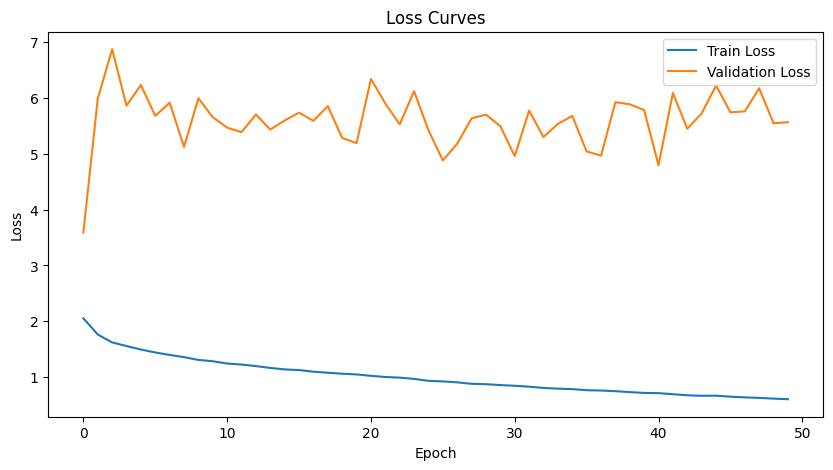

In [89]:
trainer.plot_losses()

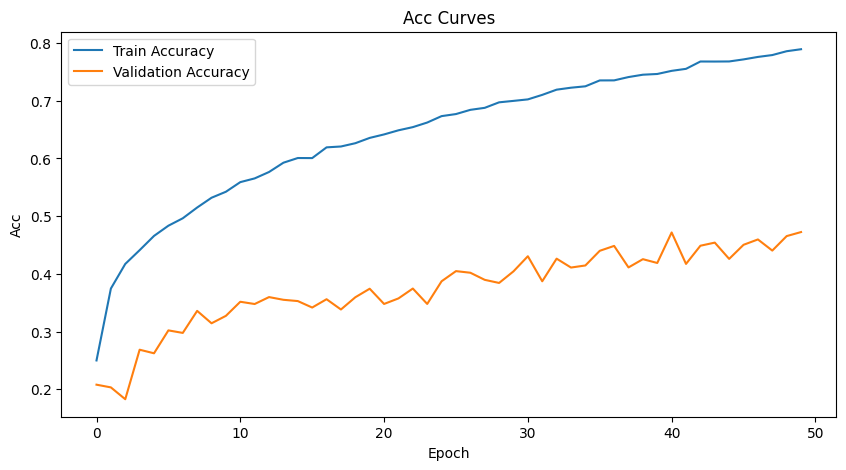

In [90]:
trainer.plot_acc()

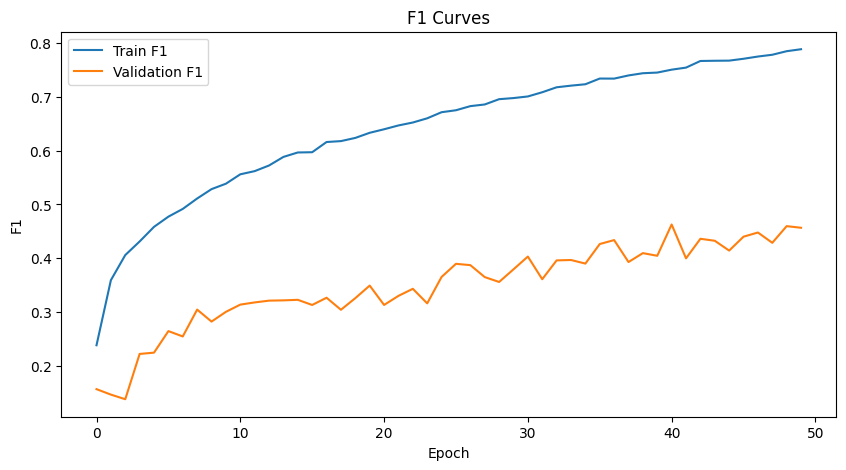

In [91]:
trainer.plot_f1()